# Limpeza de dados
 - Introdução à limpeza de dados
 - Correção de erros e inconsistências
 - Tratamento de dados discrepantes (outliers)
 - Tratamento de dados faltantes
 - Como usar tudo isso?
---

## Introdução à limpeza de dados
 - Do que se trata?
 - O que são "dados sujos" e quais seus principais tipos?
 - Por que realizar?

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# simulação de conjuntos de dados
from sklearn.datasets import make_blobs

# pipelines e transformadores
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer

# dados discrepantes
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

# dados faltantes
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression # modelo para imputação quantitativa

# normalização
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# para facilitar os exemplos
from sklearn import set_config
set_config(transform_output = "pandas")

## Correção de erros e inconsistências

In [ ]:
# @title Datas inconsistentes
df_taxis = sns.load_dataset("taxis")
np.random.seed(42)
df_taxis["pickup"] = df_taxis["pickup"].astype(str)

# Introduzir formatos diferentes de datas para simular um erro real
formatos_errados = [
    "%Y-%m-%d %H:%M:%S",  # Correto
    "%d-%m-%Y %H:%M:%S",  # Dia primeiro
    "%Y/%m/%d %H:%M",     # Com barras e sem segundos
    "%m-%d-%Y %H:%M:%S",  # Mês primeiro
]

# Aplicar formatos misturados em algumas linhas
for i in range(len(df_taxis)):
    df_taxis.loc[i, "pickup"] = pd.to_datetime(df_taxis.loc[i, "pickup"]).strftime(np.random.choice(formatos_errados))
display(df_taxis["pickup"].head())

,pickup
0,2019/03/23 20:21
1,03-04-2019 16:11:55
2,2019-03-27 17:53:01
3,2019/03/10 01:23
4,2019/03/30 13:27


In [ ]:
# Correção
def corrigir_data(x):
    formatos_tentativas = [
        "%Y-%m-%d %H:%M:%S", "%d-%m-%Y %H:%M:%S",
        "%Y/%m/%d %H:%M","%m-%d-%Y %H:%M:%S"
    ]
    for fmt in formatos_tentativas:
        try:
            return pd.to_datetime(x, format=fmt)
        except ValueError:
            continue
    return np.nan

# Aplicar a correção
df_taxis["pickup"] = df_taxis["pickup"].apply(corrigir_data)
display(df_taxis["pickup"].head())

,pickup
0,2019-03-23 20:21:00
1,2019-04-03 16:11:55
2,2019-03-27 17:53:01
3,2019-03-10 01:23:00
4,2019-03-30 13:27:00


In [ ]:
# @title Erros de digitação
df = pd.read_csv('https://raw.githubusercontent.com/atlantico-academy/datasets/refs/heads/main/mpg.csv')
df_car = df.copy() # somente para exemplo
df_car['original_horsepower'] = df_car['horsepower'] # somente para exemplo
display(df.head())
print(df.info())

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB
None


In [ ]:
correcoes = {
    'chevy': 'chevrolet',
    'toyouta': 'toyota',
    'maxda': 'mazda',
    'chevroelt': 'chevrolet',
    'vw': 'volkswagen',
    'vokswagen': 'volkswagen',
    'mercedes-benz': 'mercedes',
    'capri': 'ford'
}
df["name"] = df.name.replace(regex=correcoes)

## Tratamento de dados faltantes
![](https://www.qresearchsoftware.com/wp-content/uploads/shutterstock_1063994258.jpg)
 - O que são dados faltantes?
 - Tipo de dado faltante: MCAR, MAR, MNAR
 - Abordagens para tratamento
    - Deleção:
        - Linhas
        - Colunas
    - Imputação:
        - Estatísticas de tendência central
        - Métodos de aprendizado de máquina


In [ ]:
# @title Missing At Random (MAR)

np.random.seed(42)
missing_mask = df["model_year"].apply(lambda year: np.random.rand() < (0.05 * (82 - year)))
df.loc[missing_mask, "horsepower"] = np.nan

# Verificar a porcentagem de valores ausentes
nan_percentages = df.isnull().mean() * 100
nan_percentages.name = 'percentage'
nan_percentages.sort_values(ascending=False)

,percentage
horsepower,33.668342
mpg,0.000000
cylinders,0.000000
displacement,0.000000
weight,0.000000
acceleration,0.000000
model_year,0.000000
origin,0.000000
name,0.000000


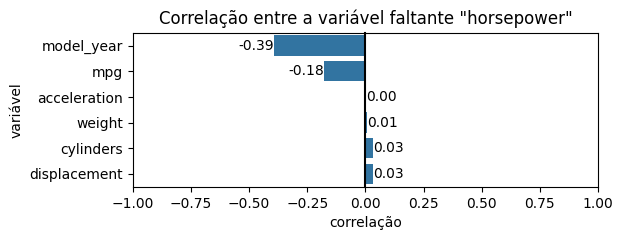

In [ ]:
# computo de correlação entre dados faltantes
# sns.set_theme(style="white", context="talk")
df_null = df.loc[:,df.isnull().sum() > 0].isnull()
df_ = df.copy()
new_columns = []
for column in df_null.columns:
    new_columns.append(f"{column}_null")
    df_[f"{column}_null"] = df_null[column]
corr = df_.corr(numeric_only=True)

# plot
graph_df = corr[new_columns].reset_index(names='variable')
graph_df = graph_df.query('variable not in ["horsepower_null", "horsepower"]')
plt.figure(figsize=(6, 2))
ax = sns.barplot(
    data=graph_df,
    x='horsepower_null', y='variable',
    order = graph_df.sort_values(by='horsepower_null').variable,
)
ax.set(
    xlim=[-1, 1], xlabel='correlação', ylabel='variável',
    title='Correlação entre a variável faltante "horsepower"'
)
ax.bar_label(ax.containers[0], fmt="%.2f")
ax.axvline(0, color="k", clip_on=False)
plt.show()

In [ ]:
# @title Exclusão de linhas e/ou colunas
df_without_null_rows = df.dropna(axis=0)
display(df_without_null_rows)

df_without_null_cols = df.dropna(axis=1)
display(df_without_null_cols)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
7,14.0,8,440.0,215.0,4312,8.5,70,usa,plymouth fury iii
8,14.0,8,455.0,225.0,4425,10.0,70,usa,pontiac catalina
9,15.0,8,390.0,190.0,3850,8.5,70,usa,amc ambassador dpl
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,europe,volkswagen pickup
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger


,mpg,cylinders,displacement,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,3449,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,2790,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,2130,24.6,82,europe,volkswagen pickup
395,32.0,4,135.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,2625,18.6,82,usa,ford ranger


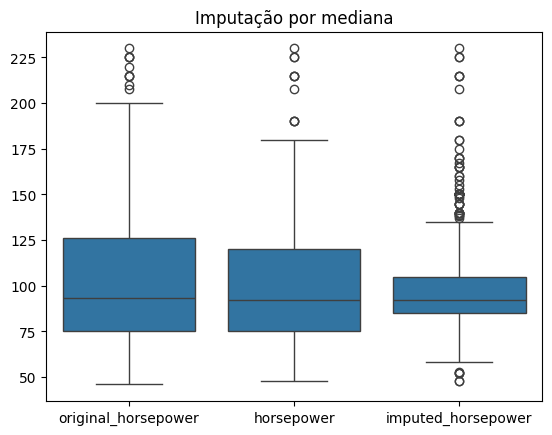

In [ ]:
# @title Imputação por estatísticas de tendência central (`SimpleImputer`)
# usar a mediana
imputer = SimpleImputer(strategy='median')
imputer.fit(df[['horsepower']])

df['imputed_horsepower'] = imputer.transform(df[['horsepower']])

ax = sns.boxplot(df_car[['original_horsepower']])
ax = sns.boxplot(df[['horsepower']])
ax = sns.boxplot(df[['imputed_horsepower']])
ax.set(title="Imputação por mediana")
plt.show()

df = df.drop(columns="imputed_horsepower")

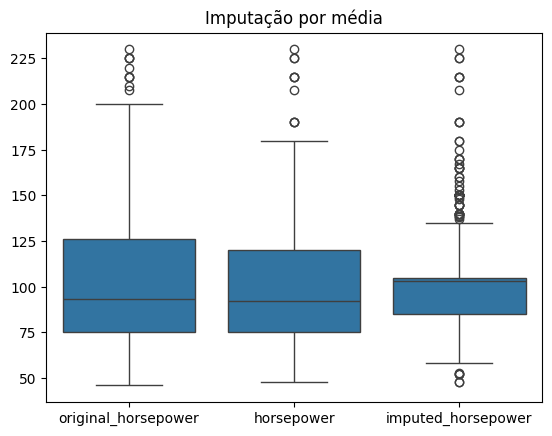

In [ ]:
# usar a média

imputer = SimpleImputer(strategy='mean')
imputer.fit(df[['horsepower']])

df['imputed_horsepower'] = imputer.transform(df[['horsepower']])

ax = sns.boxplot(df_car[['original_horsepower']])
ax = sns.boxplot(df[['horsepower']])
ax = sns.boxplot(df[['imputed_horsepower']])
ax.set(title="Imputação por média")
plt.show()

df = df.drop(columns="imputed_horsepower")


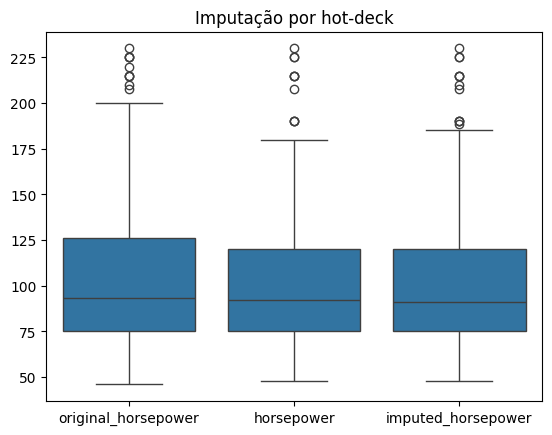

In [ ]:
# @title Imputação por hot-deck (`KNNImputer`)

numeric_columns = [
    'mpg', 'cylinders', 'displacement', 'horsepower',
    'weight', 'acceleration', 'model_year'
]

imputer = KNNImputer()
imputer.fit(df[numeric_columns])


df['imputed_horsepower'] = imputer.transform(df[numeric_columns])['horsepower']


ax = sns.boxplot(df_car[['original_horsepower']])
ax = sns.boxplot(df[['horsepower']])
ax = sns.boxplot(df[['imputed_horsepower']])
ax.set(title="Imputação por hot-deck")
plt.show()

df = df.drop(columns="imputed_horsepower")


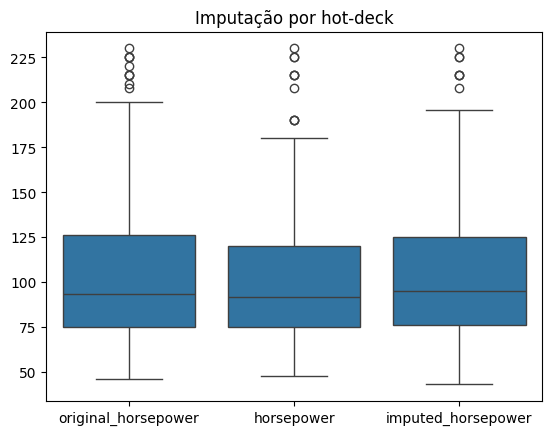

In [ ]:
# @title Imputação por modelos de aprendizado de máquina (`IterativeImputer`)
# usar um modelo para imputar
numeric_columns = [
    'mpg', 'cylinders', 'displacement', 'horsepower',
    'weight', 'acceleration', 'model_year'
]

imputer = IterativeImputer(estimator=LinearRegression())
imputer.fit(df[numeric_columns])

df['imputed_horsepower'] = imputer.transform(df[numeric_columns])['horsepower']
ax = sns.boxplot(df_car[['original_horsepower']])
ax = sns.boxplot(df[['horsepower']])
ax = sns.boxplot(df[['imputed_horsepower']])
ax.set(title="Imputação por hot-deck")
plt.show()

df = df.drop(columns="imputed_horsepower")


In [ ]:
# @title Imputação de variáveis qualitativas (tarefa de casa)

## Tratamento de dados discrepantes

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*okf9pg4JjvNHyrjW)

 - Podem existir dados discrepantes em variáveis qualitativas?
 - De onde surgem os dados discrepantes?

### Identificação
 - Intervalo interquartil: $x_n < Q_1 - (1.5 \times IQR)$ ou $x_n > Q_3 + (1.5 \times IQR)$
 - Regra dos desvios padrão: $\left|\frac{x_n - \bar{x}}{s}\right| > k$, com $k \in \mathbb{R}^+$
 - Modelos de aprendizado de máquina.

In [ ]:
# configuração para geração de exemplos de dados aleatórios
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

blobs_params = {
    "random_state": 42,
    'n_samples': n_inliers,
    'n_features': 2
}

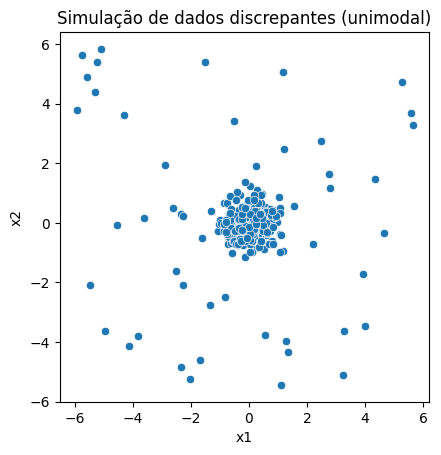

In [ ]:
rng = np.random.RandomState(42)
X = (
    np
    .concatenate([
        make_blobs(centers=np.zeros((2,2)), cluster_std=0.5, **blobs_params)[0],
        rng.uniform(low=-6, high=6, size=(n_outliers, 2))
    ], axis=0)
)

df = pd.DataFrame(
    X,
    columns = ['x1', 'x2']
)


# plot
ax = sns.scatterplot(data=df, x='x1', y='x2')
ax.set(title="Simulação de dados discrepantes (unimodal)", box_aspect=1)
plt.show()

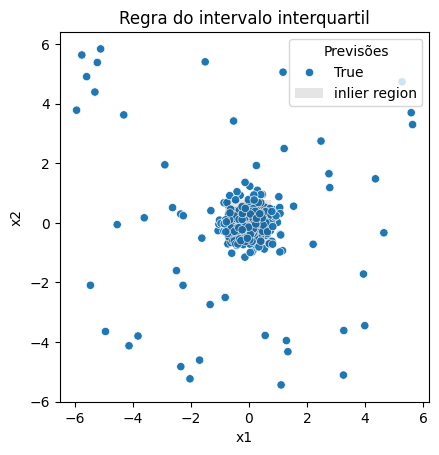

In [ ]:
# @title Regra do intervalo interquartil
q1 = df.quantile(.25)
q3 = df.quantile(.75)
iqr = q3 - q1

upper_bound = q1 + (iqr*1.5)
lower_bound = q3 - (iqr*1.5)



detected_outliers = ((df <= upper_bound) | (df >= lower_bound)).any(axis=1)

# plot
ax = sns.scatterplot(data=df, x='x1', y='x2', hue=detected_outliers)
rect = plt.Rectangle(
    (lower_bound['x1'], lower_bound['x2']),
    upper_bound['x1'] - lower_bound['x1'],
    upper_bound['x2'] - lower_bound['x2'],
    facecolor="black",
    alpha=0.1,
    label='inlier region'
)
ax.add_patch(rect)
ax.set(title="Regra do intervalo interquartil", box_aspect=1)
plt.legend(title="Previsões")

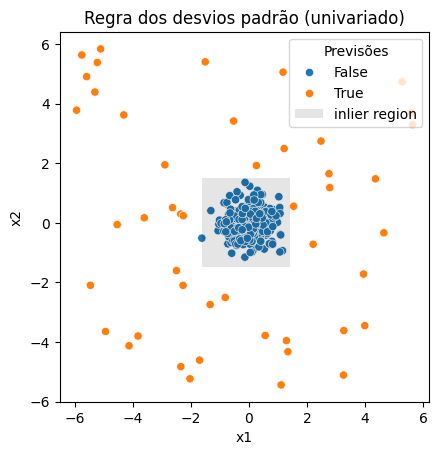

In [ ]:
# @title Regra dos desvios padrão (univariado)

k = 1.03

upper_bound = df.mean() + k * df.std()
lower_bound = df.mean() - k * df.std()


detected_outliers = ((df >= upper_bound) | (df <= lower_bound)).any(axis=1)

#plot
ax = sns.scatterplot(data=df, x='x1', y='x2', hue=detected_outliers)
rect = plt.Rectangle(
    (lower_bound['x1'], lower_bound['x2']),
    upper_bound['x1'] - lower_bound['x1'],
    upper_bound['x2'] - lower_bound['x2'],
    facecolor="black",
    alpha=0.1,
    label='inlier region'
)
ax.add_patch(rect)
ax.set(title="Regra dos desvios padrão (univariado)", box_aspect=1)
plt.legend(title="Previsões")

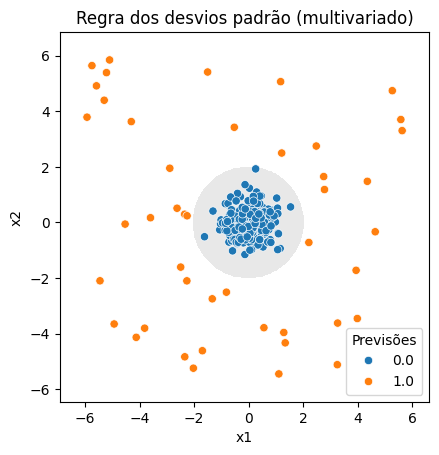

In [ ]:
# @title Regra dos desvios padrão (multivariado)

detector = EllipticEnvelope(contamination=0.15, random_state=42)
detector.fit(df)
detected_outliers = (detector.fit_predict(df)*(-1) + 1)/2

# Plotando os dados com outliers destacados
# Desenha a região de confiança
xx, yy = np.meshgrid(
    np.linspace(df['x1'].min()-1, df['x1'].max()+1, 500),
    np.linspace(df['x2'].min()-1, df['x2'].max()+1, 500)
)
Z = detector.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1', 'x2']))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=[0, 1], colors=['lightgray'], alpha=0.5)  # Linha preta separa normal/outlier
ax = sns.scatterplot(data=df, x='x1', y='x2', hue=detected_outliers)
ax.set(title="Regra dos desvios padrão (multivariado)", box_aspect=1)
plt.legend(title="Previsões")
plt.show()

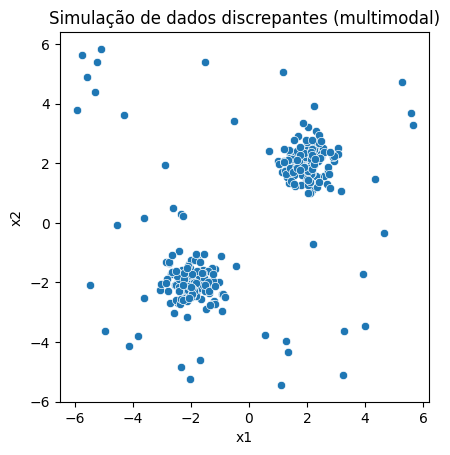

In [ ]:
# simulação de dados multimodais
rng = np.random.RandomState(42)
X = (
    np
    .concatenate([
        make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
        rng.uniform(low=-6, high=6, size=(n_outliers, 2))
    ], axis=0)
)

df = pd.DataFrame(
    X,
    columns = ['x1', 'x2']
)


# plot
ax = sns.scatterplot(data=df, x='x1', y='x2')
ax.set(title="Simulação de dados discrepantes (multimodal)", box_aspect=1)
plt.show()

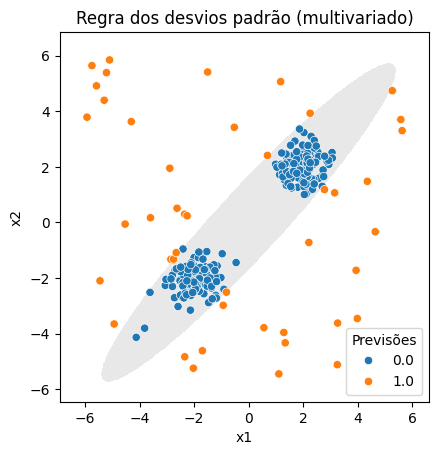

In [ ]:
# Regra dos desvios padrão (multivariado em dados bimodais)

detector = EllipticEnvelope(contamination=0.15, random_state=42)
detector.fit(df)
detected_outliers = (detector.fit_predict(df)*(-1) + 1)/2

# Desenha a região de confiança
xx, yy = np.meshgrid(
    np.linspace(df['x1'].min()-1, df['x1'].max()+1, 500),
    np.linspace(df['x2'].min()-1, df['x2'].max()+1, 500)
)

Z = detector.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1', 'x2']))
Z = Z.reshape(xx.shape)


# Plotando os dados com outliers destacados
plt.contourf(xx, yy, Z, levels=[0, 1], colors=['lightgray'], alpha=0.5)  # Linha preta separa normal/outlier
ax = sns.scatterplot(data=df, x='x1', y='x2', hue=detected_outliers)

ax.set(title="Regra dos desvios padrão (multivariado)", box_aspect=1)
plt.legend(title='Previsões')
plt.show()

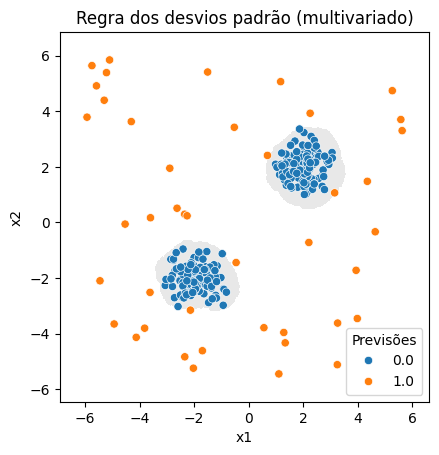

In [ ]:
# @title Modelos de aprendizado de máquina
detector = LocalOutlierFactor(contamination=0.15, novelty=True)
detector.fit(df.values)
# Identifica os outliers
detected_outliers = (detector.predict(df.values)*(-1) + 1)/2


# Desenha a região de confiança
xx, yy = np.meshgrid(
    np.linspace(df['x1'].min()-1, df['x1'].max()+1, 500),
    np.linspace(df['x2'].min()-1, df['x2'].max()+1, 500)
)

Z = detector.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1', 'x2']))
Z = Z.reshape(xx.shape)


# Plotando os dados com outliers destacados
plt.contourf(xx, yy, Z, levels=[0, 1], colors=['lightgray'], alpha=0.5)  # Linha preta separa normal/outlier
ax = sns.scatterplot(data=df, x='x1', y='x2', hue=detected_outliers)

ax.set(title="Regra dos desvios padrão (multivariado)", box_aspect=1)
plt.legend(title='Previsões')
plt.show()

### Tratamento
 - Capping ou winsorização
 - Deleção de instâncias (trimming)
 - Deleção de valores

In [ ]:
# @title Capping ou Winsorização
# referência https://github.com/scikit-learn/scikit-learn/pull/11278
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, quantile=0.05, copy=True):
        self.quantile = quantile
        self.copy = copy

    def fit(self, X, y=None):
        self.data_lb_ = np.percentile(X, 100*self.quantile, axis=0, method='nearest')
        self.data_ub_ = np.percentile(X, 100*(1 - self.quantile), axis=0, method='nearest')
        return self

    def transform(self, X):
        X = np.clip(X, self.data_lb_, self.data_ub_)
        return X

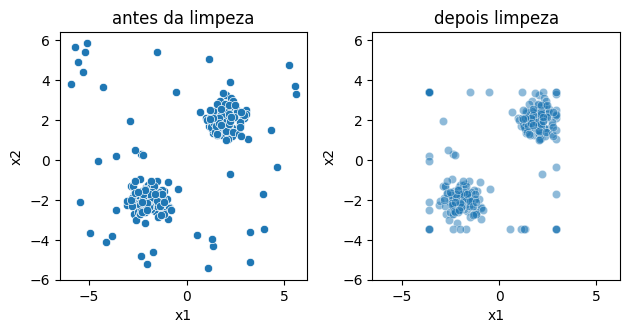

In [ ]:
# capping
outlier_detector = Winsorizer(quantile=0.04)
outlier_detector.fit(df)
df_without_outliers = outlier_detector.transform(df)

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = sns.scatterplot(data=df, x='x1', y='x2', ax=axes[0])
ax.set(title="antes da limpeza", box_aspect=1)
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
ax = sns.scatterplot(data=df_without_outliers, x='x1', y='x2', ax=axes[1], alpha=.5)
ax.set(title="depois limpeza", box_aspect=1, xlim=x_lim, ylim=y_lim)
plt.tight_layout()
plt.show()

In [ ]:
# @title Deleção de instâncias (trimming)
class TrimmingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, detector, copy=True):
        self.detector = detector
        self.copy = copy

    def fit(self, X, y=None):
        self.detector.fit(X.values)
        return self

    def transform(self, X):
        X_ = X.copy()
        mask = self.detector.predict(X.values) == 1
        return X_[mask]

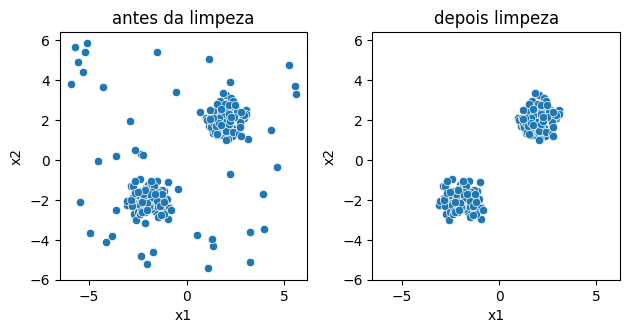

In [ ]:
detector = LocalOutlierFactor(contamination=0.15, novelty=True)
outlier_detector = TrimmingTransformer(detector=detector)
outlier_detector.fit(df)
df_without_outliers = outlier_detector.transform(df)

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = sns.scatterplot(data=df, x='x1', y='x2', ax=axes[0])
ax.set(title="antes da limpeza", box_aspect=1)
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
ax = sns.scatterplot(data=df_without_outliers, x='x1', y='x2', ax=axes[1])
ax.set(title="depois limpeza", box_aspect=1, xlim=x_lim, ylim=y_lim)
plt.tight_layout()
plt.show()

In [ ]:
# @title Remoção de valores das variáveis
class ValueRemovalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3, copy=True):
        self.n_std = n_std
        self.copy = copy

    def fit(self, X, y=None):
        X_ = X.copy()
        self.upper_bound = X_.mean() + (self.n_std * X_.std())
        self.lower_bound = X_.mean() - (self.n_std * X_.std())
        return self

    def transform(self, X):
        X_ = X.copy()
        mask = (X >= self.upper_bound) | (X <= self.lower_bound)
        X_[mask] = np.nan
        return X_

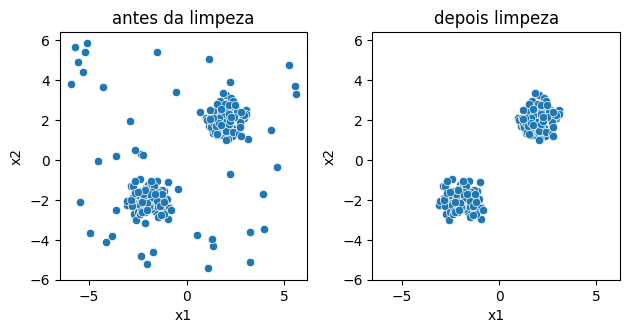

In [ ]:
outlier_detector = ValueRemovalTransformer(n_std=1.5, copy=False)
outlier_detector.fit(df)
df_marked_outliers = outlier_detector.transform(df)